## Problem 1: Understanding Principal Component Analysis (PCA)

Objective:

Implement PCA from scratch to discover low-dimensional structure in high-dimensional data.

Instructions:

- You must implement PCA using Eigenvalue/Singular Value Decomposition methods
- No use of built-in PCA implementations (e.g., sklearn.decomposition.PCA)
- You may use built-in PCA only for validation of your results

### Part 1: Discovering Structure in Synthetic Data


- In this part, we will work with a synthetic dataset that contains a hidden pattern: a 2D spiral that has been deliberately embedded in 5-dimensional space through a transformation and addition of noise.
- This represents a common real-world scenario where the true underlying structure of the data exists in a lower dimension than the observed data.
- Apply PCA to recover the original 2D spiral pattern from the 5-dimensional data.


In [28]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
from scipy.stats import special_ortho_group
import pickle

### Data Exploration and Visualization



Consider a 2D spiral given by,

\begin{align}
& x_t = t \cos(t), & y_t = t \sin(t),
\end{align}

with $ t \in [0, 4 \pi]$.

In [2]:
# hparams
n_points = 1000
n_dims = 5
noise_level = 0.2

# Create underlying 2D spiral
t = np.linspace(0, 4*np.pi, n_points)
x_hid = t * np.cos(t)
y_hid = t * np.sin(t)

Let us plot how the data looks like

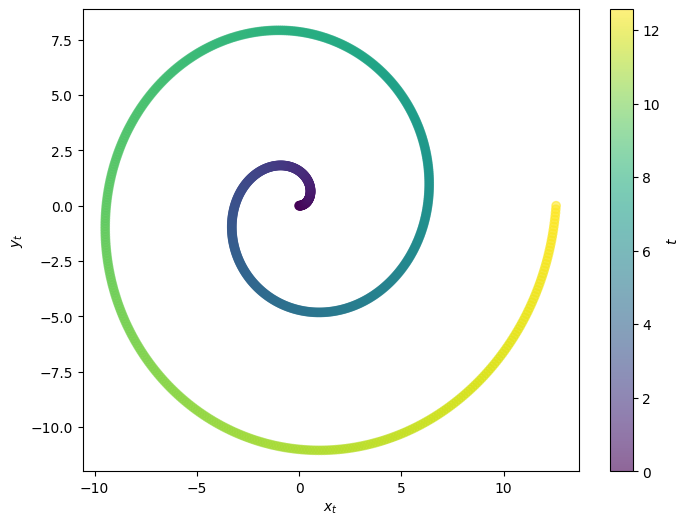

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
scatter = ax.scatter(x_hid, y_hid, c = t, cmap = 'viridis', alpha = 0.6)
ax.set_xlabel(r'$x_t$')
ax.set_ylabel(r'$y_t$')
fig.colorbar(scatter, ax = ax, label = r'$t$')

Let $z_t = \begin{bmatrix} x_t \\ y_t \end{bmatrix} \in \mathbb{R}^2$ collectively denote our two-dimensional hidden variables.

Consider the following transformation from $\mathbb{R}^2$ to $\mathbb{R}^N$:

$$
X_t = W z_t + \epsilon
$$

where:
- $W \in \mathbb{R}^{N \times 2}$ is the transformation matrix defined as $$W = R^2,$$where $R^2$ denotes the element wise square of a $R \in SO(N)$ special orthogonal matrix
- $\epsilon \sim {N}(0, \sigma^2 I_N)$ is N-dimensional Gaussian noise with variance $\sigma^2$

This transformation embeds the two-dimensional spiral into an N-dimensional space by applying the transformation matrix $W$ and adding random Gaussian noise.

In [4]:
def create_transformed_spiral_data(x_hid, y_hid, n_dims = 5, noise_level = 0.2):
    """
    Embed the 2D pattern in higher dimensions through a transformation and noise
    """

    # Create the initial data matrix with the pattern in first 2 dimensions
    data = np.zeros((n_points, n_dims))
    data[:, 0] = x_hid
    data[:, 1] = y_hid

    # Generate random orthogonal matrix for rotation
    # This preserves distances but completely mixes the dimensions
    W = special_ortho_group.rvs(n_dims, random_state = np.random.seed(42))**2

    # Apply rotation
    X = np.dot(data, W)

    # Add noise to all dimensions
    noise = np.random.normal(0, noise_level, (n_points, n_dims))
    data_tranformed = X + noise

    return data_tranformed, W

np.random.seed(42)

# Generate data
X, W = create_transformed_spiral_data(x_hid, y_hid, n_dims = 5, noise_level = 0.2)
# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Let us look how does the individual coordinates look like after the transformation

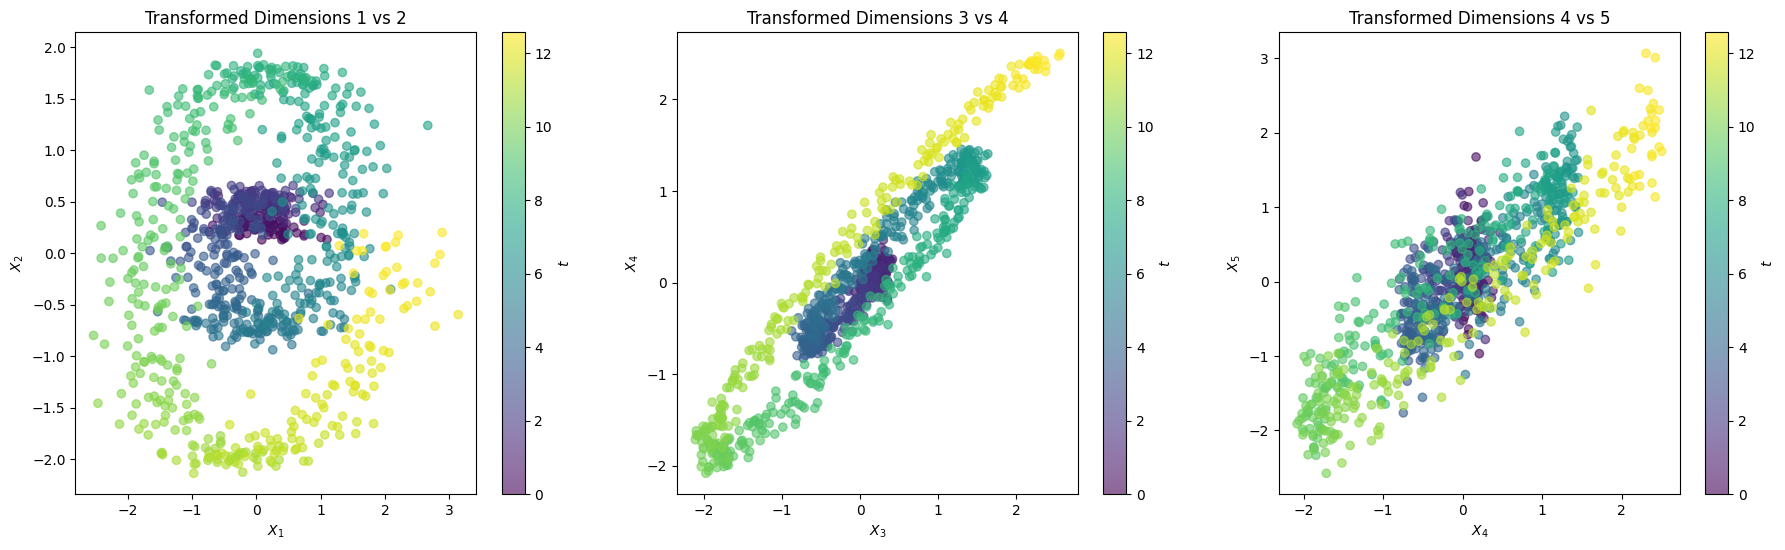

In [5]:
# Create visualization
fig, axes = plt.subplots(1, 3, figsize = (22, 6))

pairs = [(0, 1), (2, 3), (3, 4)]
for i, (dim1, dim2) in enumerate(pairs):
    scatter = axes[i].scatter(X_scaled[:, dim1], X_scaled[:, dim2],  c = t, cmap = 'viridis', alpha = 0.6)
    axes[i].set_title(f'Transformed Dimensions {dim1+1} vs {dim2+1}')
    axes[i].set_xlabel(fr'$X_{(dim1+1)}$')
    axes[i].set_ylabel(fr'$X_{(dim2+1)}$')
    plt.colorbar(scatter, ax = axes[i], label = r'$t$')

### Task: Dimensionality Reduction of the synthetic datas using PCA

- Implement and Apply your PCA implementation to the 5-dimensional transformed data
- Extract the first two principal components
- Create a scatter plot of the data projected onto the first two principal components
- Add a colormap to represent the progression along the spiral pattern as in the visualization plots
- Compare your recovered 2D pattern with the original spiral

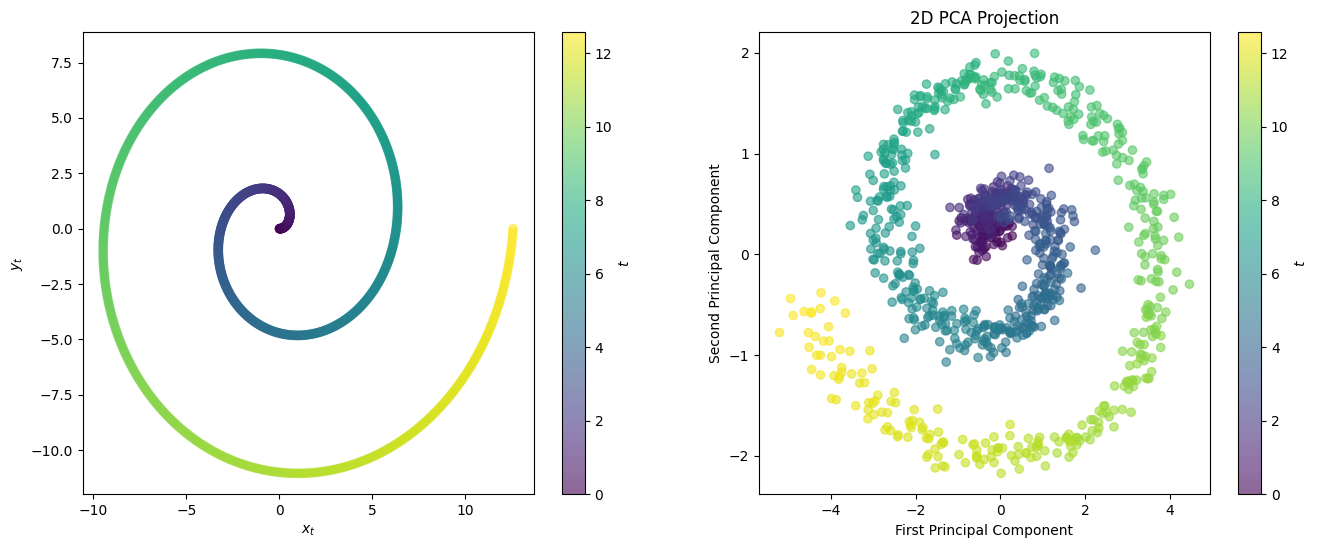

In [6]:
## NOTE: TO BE GRADED

# Perform PCA

def PCA(data, n_components):
    # normalize
    mean, std = np.mean(data, axis=0), np.std(data, axis=0)
    data_normalized = (data - mean)/std

    # covariance matrix
    cov = np.cov(data_normalized, rowvar=False)

    # eigenvalues, eigenvectors of covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # sort eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # principal components
    principal_components = eigenvectors[:, :n_components]

    # reduced data
    reduced_data = data_normalized @ principal_components

    return reduced_data



#data_pca = np.zeros(shape = (n_points, n_dims)) # replace with the PCA result

data_pca = PCA(X_scaled, 2)

# Plot the PCA result along with the original data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# plot the original data
ax = axes[0]
scatter = ax.scatter(x_hid, y_hid, c = t, cmap = 'viridis', alpha = 0.6)
ax.set_xlabel(r'$x_t$')
ax.set_ylabel(r'$y_t$')
fig.colorbar(scatter, ax = ax, label = r'$t$')

# plot the PCA data
ax = axes[1]
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], c = t, cmap = 'viridis', alpha = 0.6)
ax.set_title(f'2D PCA Projection')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
fig.colorbar(scatter, ax = ax, label = r'$t$')


#### with scikit-learn

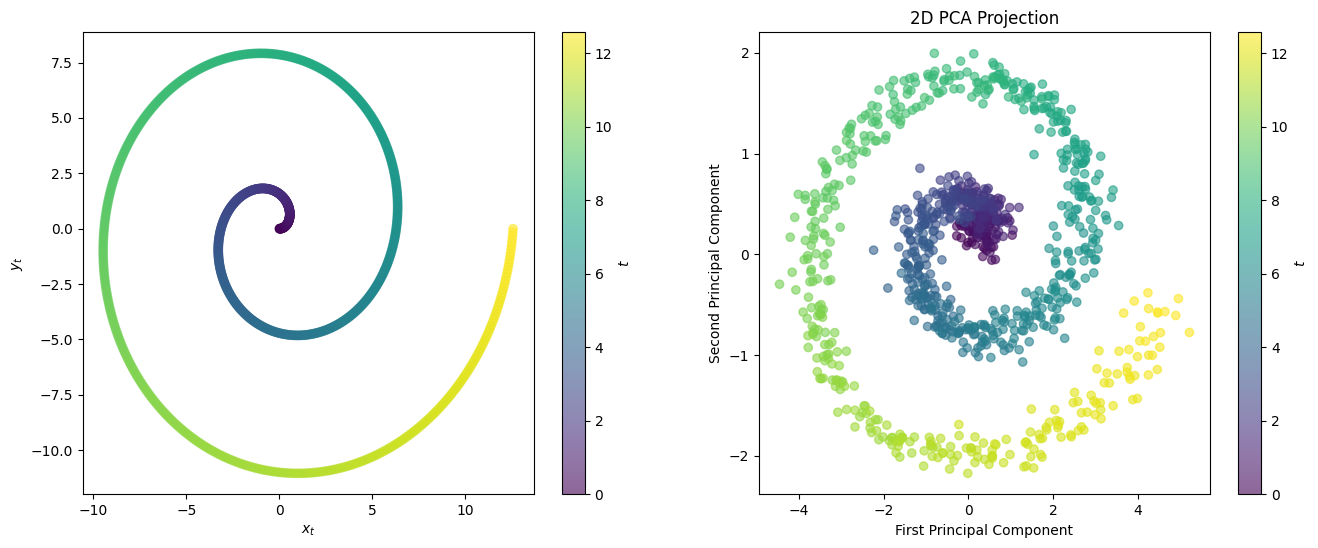

In [31]:
PCA = sklearn.decomposition.PCA(n_components=2)
data_pca = PCA.fit_transform(X_scaled)


# Plot the PCA result along with the original data
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# plot the original data
ax = axes[0]
scatter = ax.scatter(x_hid, y_hid, c = t, cmap = 'viridis', alpha = 0.6)
ax.set_xlabel(r'$x_t$')
ax.set_ylabel(r'$y_t$')
fig.colorbar(scatter, ax = ax, label = r'$t$')

# plot the PCA data
ax = axes[1]
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], c = t, cmap = 'viridis', alpha = 0.6)
ax.set_title(f'2D PCA Projection')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
fig.colorbar(scatter, ax = ax, label = r'$t$')


### Part 2: PCA Application to MNIST dataset

In this part, we will apply PCA to analyze and visualize the structure of handwritten digits from the MNIST dataset.

In [32]:
#Helper functions
def _one_hot(x, k, dtype = np.float32):
  """Description: Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)

def _standardize(x):
  """Description: Standardization per sample across feature dimension."""
  axes = tuple(range(1, len(x.shape)))
  mean = np.mean(x, axis=axes, keepdims=True)
  std_dev = np.std(x, axis=axes, keepdims=True)
  return (x - mean) / std_dev


def load_data(dataset, num_classes):
    """Description: loads mnist dataset from google drive"""
    path = f'../datasets/{dataset}/{dataset}.dump'
    in_file = open(path, 'rb')
    (x_train, y_train), (x_test, y_test) = pickle.load(in_file)

    #flatten x_train and x_test
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)

    #standardize input
    x_train, x_test = _standardize(x_train), _standardize(x_test)

    #get info about the numner of training and testing exammples
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]

    in_dim = x_train.shape[1]
    out_dim = num_classes

    return (x_train, y_train), (x_test, y_test), (num_train, num_test), (in_dim, out_dim)

Load the MNIST dataset

In [33]:
# Load MNIST
(x_train, y_train), (x_test, y_test), (num_train, num_test), (in_dim, out_dim) = load_data('mnist', num_classes = 10)

### Task 1: Perform PCA of the MNIST dataset
- For simplicity, use the test dataset x_test

In [43]:
## TO BE GRADED
# perform PCA

def PCA(data, n_components):
    # normalize
    mean, std = np.mean(data, axis=0), np.std(data, axis=0)
    data_normalized = (data - mean)/std

    # covariance matrix
    cov = np.cov(data_normalized, rowvar=False)

    # eigenvalues, eigenvectors of covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # sort eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # principal components
    principal_components = eigenvectors[:, :n_components]

    # reduced data
    reduced_data = data_normalized @ principal_components

    return reduced_data, eigenvalues, principal_components, mean, std

data_pca, eigvalues, data_pcs, data_mean, data_std = PCA(x_test, 50)

### Task2: Analyzing PCA Eigenvalues

- Plot the eigenvalue ratio $R_i = \frac{\lambda_i}{\sum_j \lambda_j}$ as a function of the index $i$.
- Also, plot the cummulative ration upto index $C_n =  \sum_j^{n} R_i$ up to index $n$.

Text(0, 0.5, '$C_n$')

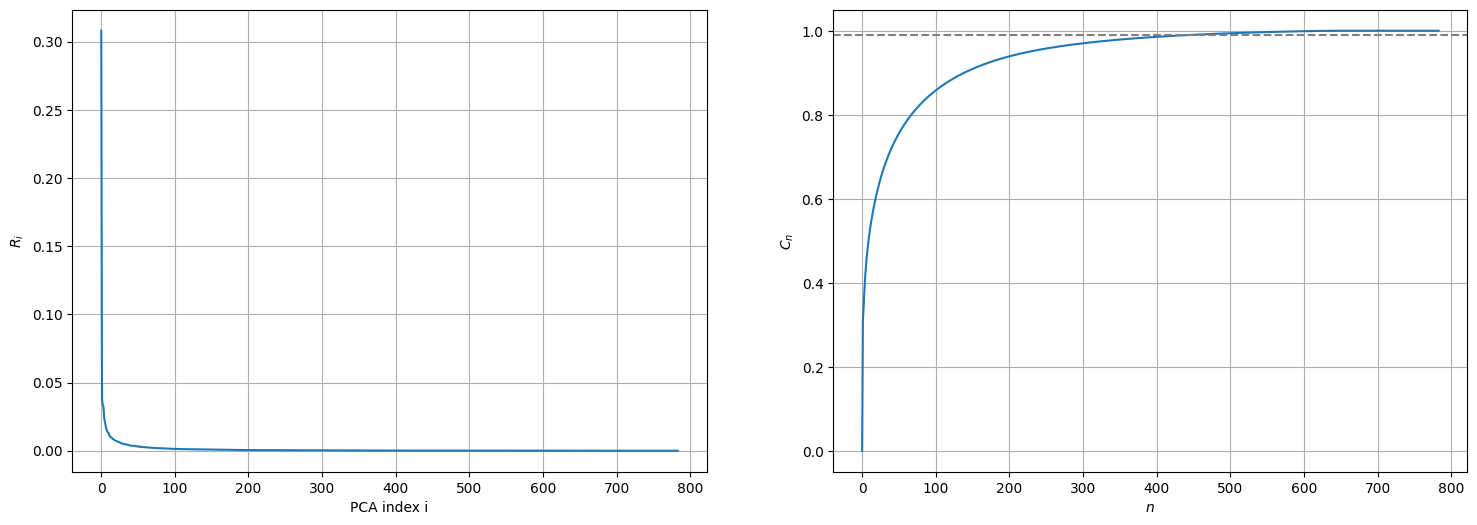

In [35]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))
ax = axes[0]
ax.plot(np.arange(len(eigvalues)),[eigvalues[i]/eigvalues.sum() for i in range(len(eigvalues))])
ax.set_xlabel('PCA index i')
ax.set_ylabel(r'$R_i$')
ax.grid(True)


ax = axes[1]
ax.grid(True)
ax.plot(np.arange(len(eigvalues)),[(eigvalues[:i]/eigvalues.sum()).sum() for i in range(len(eigvalues))])
ax.axhline(y = 0.99, linestyle = '--', color = 'gray')
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$C_n$')

### Task 3: Image Reconstruction

- Reconstruct MNIST images using the top 50 eigenvalues.
- For each image, show the constructed image with along with the original image

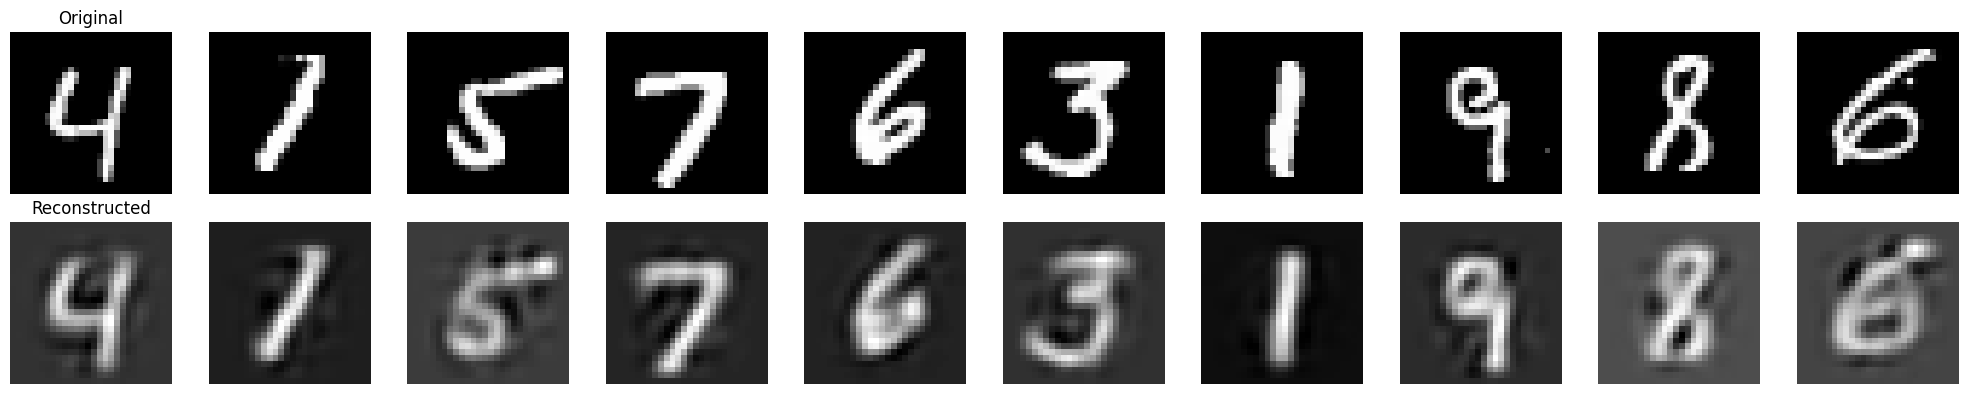

In [36]:
# Compare original vs reconstructed images
def plot_reconstructions(x_original, x_reconstructed, indices, nrows=2):
    fig, axes = plt.subplots(nrows, 10, figsize = (20, nrows*2))

    for i, idx in enumerate(indices):
        # Original
        axes[0, i].imshow(x_original[idx].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')

        # Reconstructed
        axes[1, i].imshow(x_reconstructed[idx].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()

# Reconstruct using different numbers of components
n_components = 50  # number of PCA
# TO BE GRADED
def reconstruct_data(reduced_data, principal_components, mean, std):
    #print(reduced_data.shape, principal_components.shape)
    return (reduced_data@ principal_components.T)*std + mean



#x_reconstructed = np.zeros(shape = (num_test, 50))
x_reconstructed = reconstruct_data(data_pca, data_pcs, data_mean, data_std)

# Show some random examples
random_indices = np.random.choice(len(x_test), 10, replace = False)
plot_reconstructions(x_test, x_reconstructed, random_indices)

#### with scikit-learn

In [45]:
x_pca.shape, data_pca.shape, x_pcs.shape, data_pcs.shape

((10000, 50), (10000, 50), (50, 784), (784, 50))

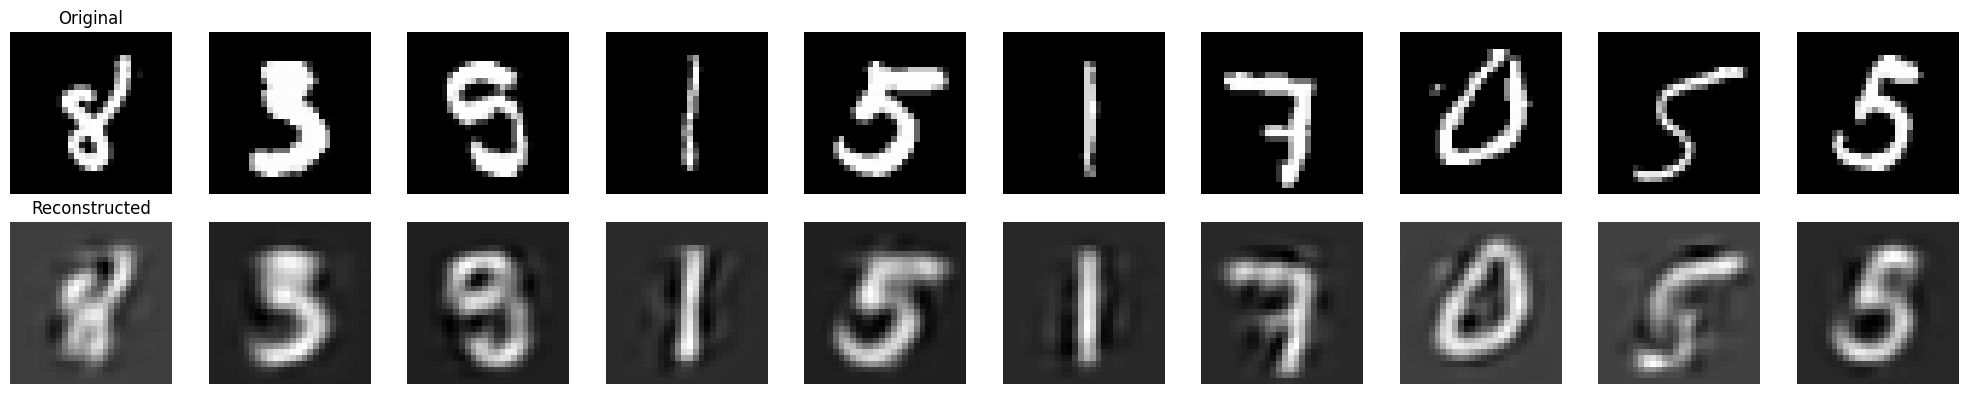

In [ ]:
PCA = sklearn.decomposition.PCA(n_components=50)

x_test_mean, x_test_std = np.mean(x_test, axis=0), np.std(x_test, axis=0)
x_test_scaled = (x_test - x_test_mean)/x_test_std


x_pca = PCA.fit_transform(x_test_scaled)
x_pcs = PCA.components_


def reconstruct_data_sklearn(reduced_data, principal_components, mean, std):
    # print(reduced_data.shape, principal_components.shape)
    return (reduced_data @ principal_components)*std + mean


# x_reconstructed = np.zeros(shape = (num_test, 50))
# x_reconstructed = reconstruct_data_sklearn(x_pca, x_pcs, x_test_mean, x_test_std)
x_reconstructed = PCA.inverse_transform(x_pca)
x_reconstructed = x_test_std * x_reconstructed + x_test_mean

# Show some random examples
random_indices = np.random.choice(len(x_test), 10, replace=False)
plot_reconstructions(x_test, x_reconstructed, random_indices)

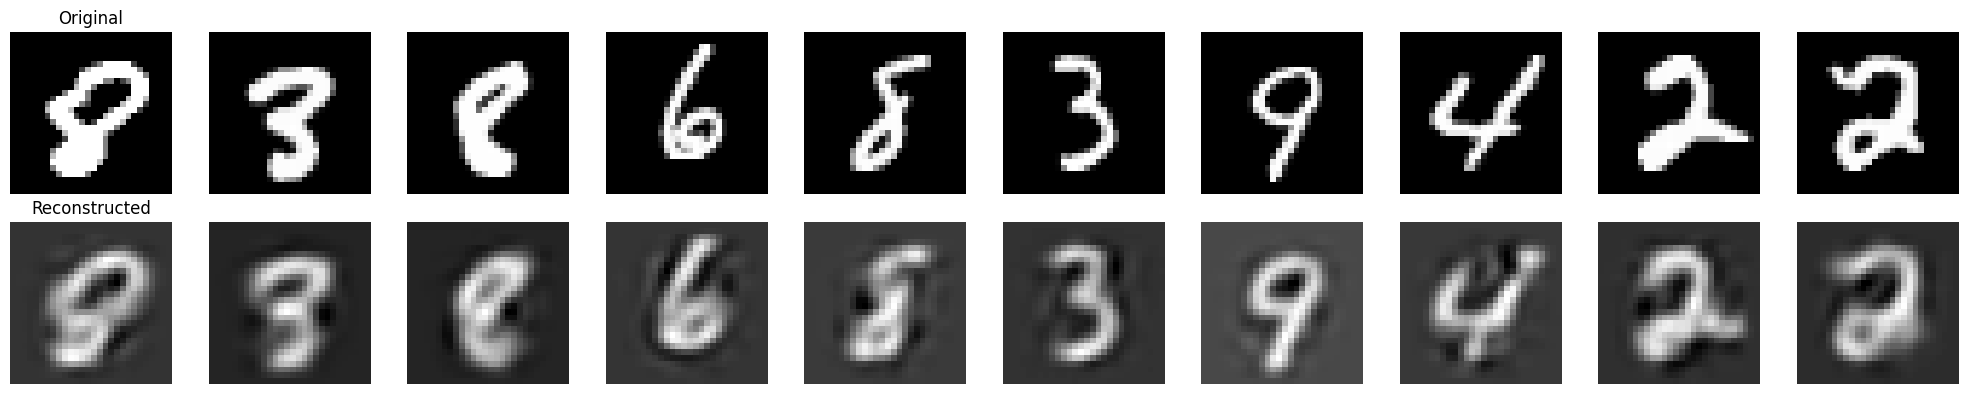

In [61]:
from sklearn.decomposition import PCA

scaler = sklearn.preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x_test)

PCA = sklearn.decomposition.PCA(n_components=50)

x_pca = PCA.fit_transform(x_scaled)

x_reconstructed_scaled = PCA.inverse_transform(x_pca)
x_reconstructed = scaler.inverse_transform(x_reconstructed_scaled)

# Show some random examples
random_indices = np.random.choice(len(x_test), 10, replace=False)
plot_reconstructions(x_test, x_reconstructed, random_indices)

## Problem 2: K-means Clustering

Objective:
Implement the K-means clustering algorithm from scratch and analyze its behavior with different parameters.

Implementation details:
- Develop K-means clustering without using built-in implementations
- Built-in implementations (e.g., sklearn.cluster.KMeans) may be used only for validation

### Part 1: Clustering Synthetic Data


### Data Generation

Create a synthetic dataset with distinct clusters
Use a mixture of different cluster shapes and sizes

In [52]:
def generate_hexagonal_clusters(n_samples = 1400, radius = 1.0, noise_level = 0.1, separation = 1.1, seed = 42):

    np.random.seed(seed)
    n_per_cluster = n_samples // 7

    # Center cluster
    center = (0, 0)

    # Generate points for surrounding clusters
    angles = np.linspace(0, 2*np.pi, 7)[:-1]  # 6 equally spaced angles
    centers = [(separation*np.cos(theta), separation*np.sin(theta))
              for theta in angles]
    centers = [center] + centers  # Add center to list of centers

    clusters = []
    labels = []

    for i, (cx, cy) in enumerate(centers):
        # Generate base circular cluster
        r = np.random.normal(radius, 0.1, n_per_cluster)
        theta = np.random.uniform(0, 2*np.pi, n_per_cluster)

        x = cx + r * np.cos(theta)
        y = cy + r * np.sin(theta)

        # Add noise
        cluster = np.column_stack([x, y])
        cluster += np.random.normal(0, noise_level, (n_per_cluster, 2))

        clusters.append(cluster)
        labels.extend([i] * n_per_cluster)

    X = np.vstack(clusters)
    y_true = np.array(labels)

    return X, y_true

# Generate data with different parameters
separation = 1.1
X, true_labels = generate_hexagonal_clusters(n_samples = 1400, radius = 0.4, noise_level = 0.1, separation = separation)

### Visualization

Let us look at the generated data

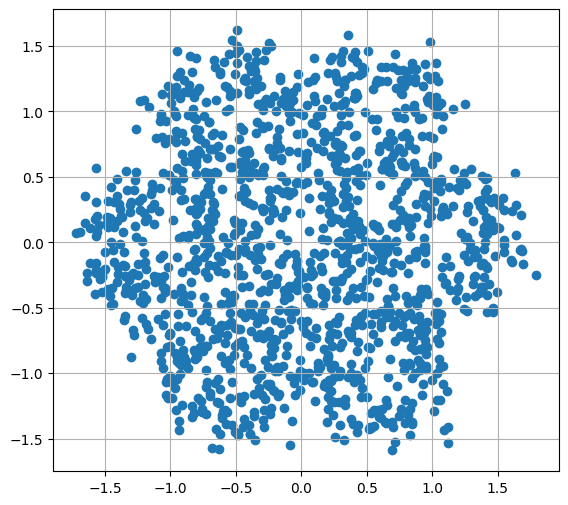

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

scatter = ax.scatter(X[:, 0], X[:, 1])
ax.grid(True)
ax.set_aspect('equal')

### Task: K-means Analysis

- Implement and run K-means with n = {3, 5, 7, 9, 11} clusters

For each value of n:

- Plot the resulting clusters with different colors
- Mark centroids distinctly
- Report the within-cluster sum of squares (WCSS)

(3, 2) (1400, 2) (1400, 1, 2) (1400, 3, 2)


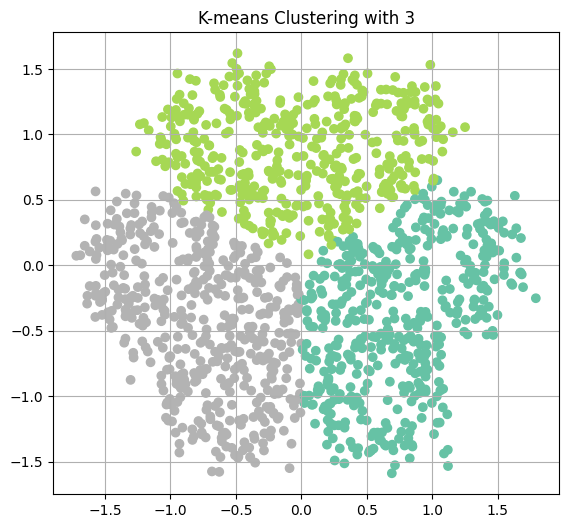

(5, 2) (1400, 2) (1400, 1, 2) (1400, 5, 2)


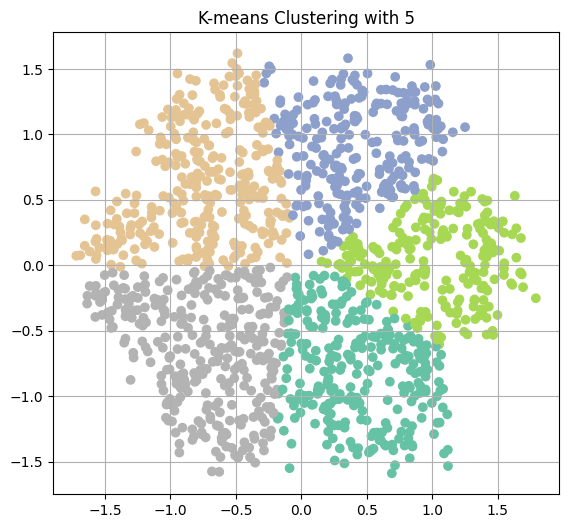

(7, 2) (1400, 2) (1400, 1, 2) (1400, 7, 2)


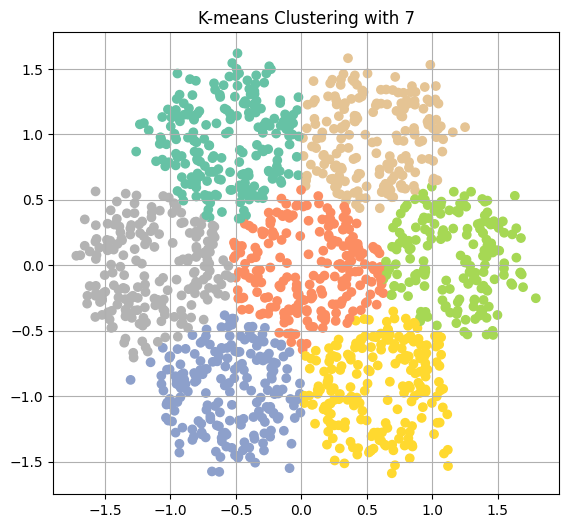

(9, 2) (1400, 2) (1400, 1, 2) (1400, 9, 2)


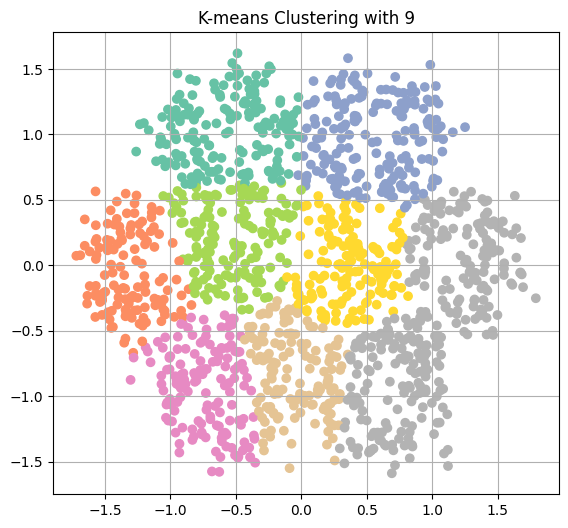

(11, 2) (1400, 2) (1400, 1, 2) (1400, 11, 2)


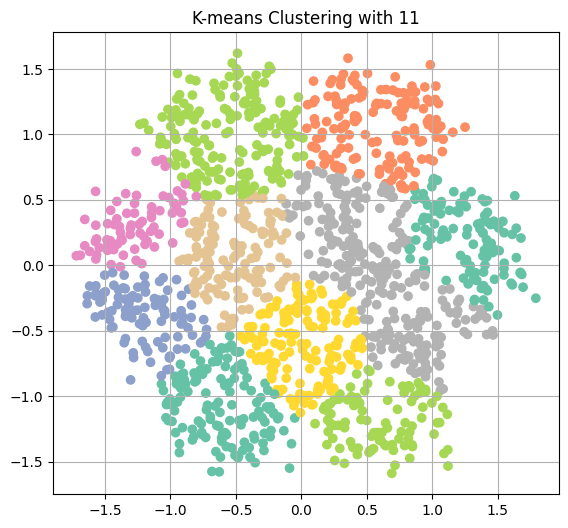

In [67]:
## TO BE GRADED
# K-means clustering

def kmeans(data, k, max_iters):
    # Randomly initialize centroids
    n_samples, n_features = data.shape
    centroids = data[np.random.choice(n_samples, k, replace=False)] # k centroids

    print(centroids.shape, data.shape, data[:, np.newaxis, :].shape, (data[:,np.newaxis, :]-centroids).shape)

    for iteration in range(max_iters):
        # Assign samples to the nearest centroid
        distances = np.linalg.norm(data[:, np.newaxis, :] - centroids, axis=2)**2  # Shape: (n_samples, k)
        labels = np.argmin(distances, axis=1)

        # Compute new centroids by average
        centroids = np.array([data[labels == i].mean(axis=0)  for i in range(k)])

    return centroids, labels

for n in [3,5,7,9,11]:
    pred_labels = kmeans(X, n, max_iters=100)[1]

    fig, ax = plt.subplots(1, 1, figsize = (8, 6))
    scatter = ax.scatter(X[:, 0], X[:, 1], c = pred_labels, cmap = 'Set2')
    ax.set_title(f'K-means Clustering with {n}')
    ax.grid(True)
    ax.set_aspect('equal')
    # ax.legend()
    plt.show()



#### scikit-learn

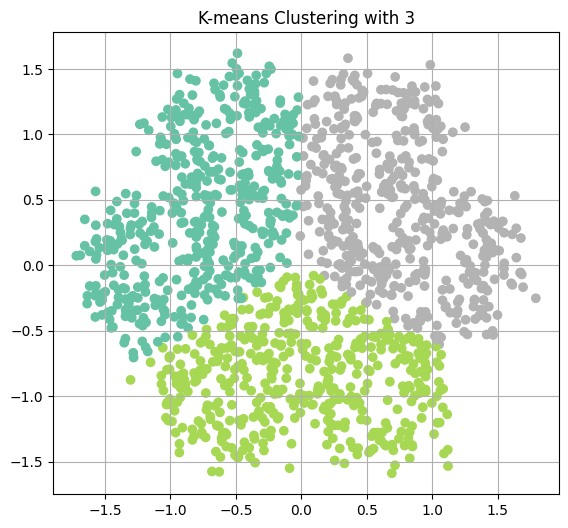

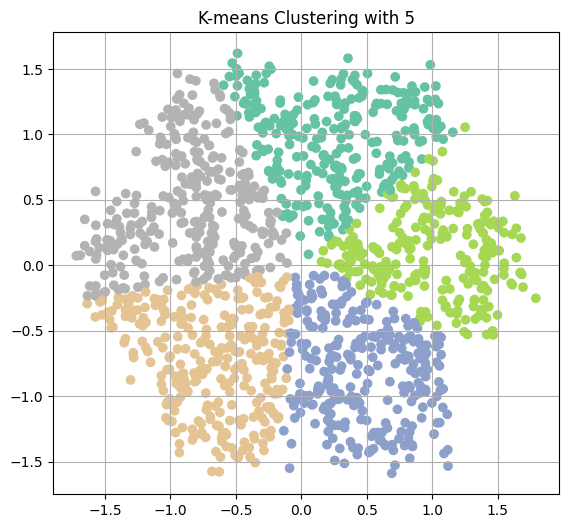

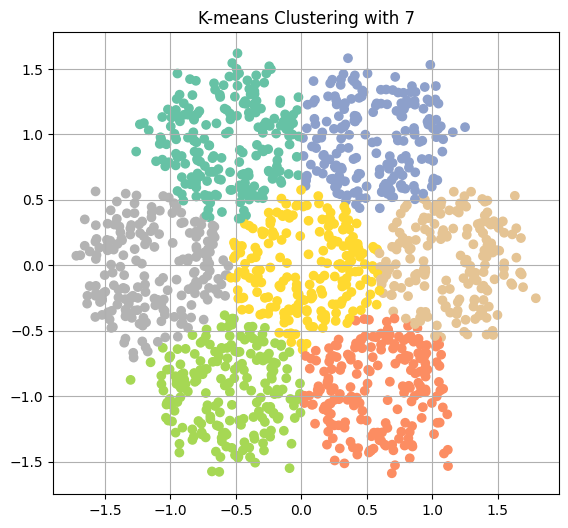

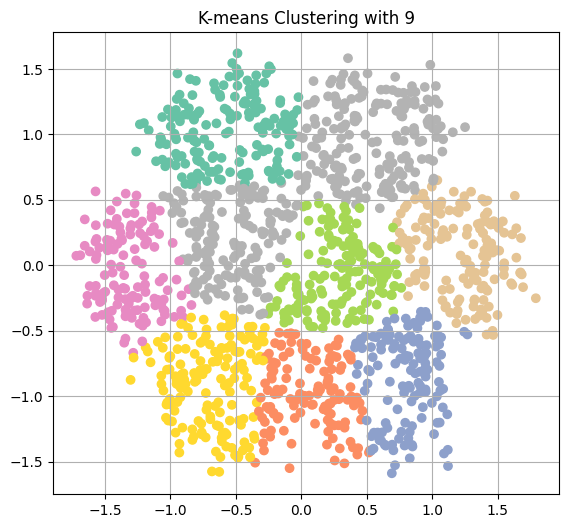

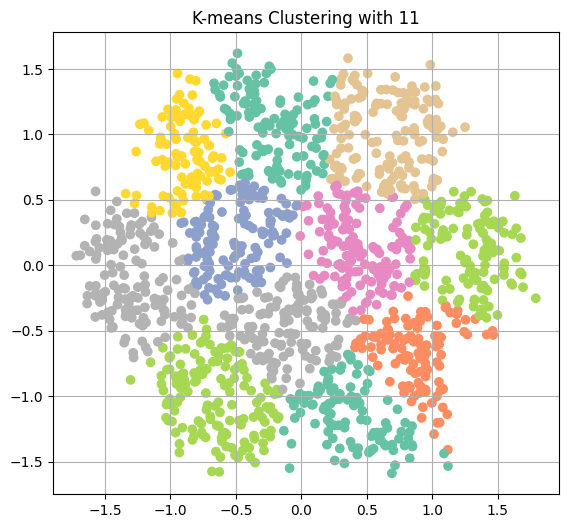

In [ ]:
for n in [3,5,7,9,11]:
    kmeans = sklearn.cluster.KMeans(n_clusters=n, random_state=0).fit(X)


    fig, ax = plt.subplots(1, 1, figsize = (8, 6))
    scatter = ax.scatter(X[:, 0], X[:, 1], c = kmeans.labels_, cmap = 'Set2')
    ax.set_title(f'K-means Clustering with {n}')
    ax.grid(True)
    ax.set_aspect('equal')
    # ax.legend()
    plt.show()